# Pricing & Matching

Scenario: Consider the scenario in which a shop has a number of promo codes to incentivize the customers that buy an item to buy a different item. The customers can belong to different classes and the promo codes can provide different discounts.

Environment: Imagine two items (referred to as first and second items; for each item we have an infinite number of units) and four customers’ classes. The daily number of customers of each class is described by a potentially different (truncated) Gaussian probability distribution. Each class is also associated with a potentially different conversion rate returning the probability that the user will buy the first item at a given price.

Once a buyer has bought the item, she/he can decide to buy the second item that can be or not promoted. There are four different promos P0, P1, P2, P3, each corresponding to a different level of discount. P0 corresponds to no discount. Given the total number of customers, the business unit of the shop decides the number of promos as a fraction of the total number of the daily customers and is fixed (use two different settings in your experiments that you are free to choose). Each customers’ class is also associated with a potentially different conversion rate returning the probability that the user will buy the second item at a given price after she/he has bought the first. The promos will affect the conversion rate as they actually reduce the price. 

Every price available is associated with a margin obtained by the sale that is known beforehand. This holds both for the first and the second item. 

The conversion rates will change during time according to some phases due to, e.g., seasonality.

## Step 1

Provide a mathematical formulation of the problem in the case in which the daily optimization is performed using the average number of customers per class. Provide an algorithm to find the optimal solution in the offline case in which all the parameters are known. Then, during the day when customers arrive, the shop uses a randomized approach to assure that a fraction of the customers of a given class gets a specified promo according to the optimal solution. For instance, at the optimal solution, a specific fraction of the customers of the first class gets P0, another fraction P1, and so on. These fractions will be used as probabilities during the day.


### Solution Step 1

**Assumption:** 

This is the mathematical formulation for the pure pricing problem of maximization of the total reward. We consider the production costs of both the item equals to zero.

**Variables definition:**

$i$ = class <br>
$j$ = promo code -> {P0, P1, P2, P3} [%]<br>
$p1$ = full price item 1  <br>
$p2$ = full price item 2<br>
$p2_j$ = price of item 2 when applied the promo j<br>
$c1$ = production cost item 1 = 0<br>
$c2$ = production cost item 2 = 0<br>
$q1_i(p1)$ = conversion rate per class i for product 1 based on price p1<br>
$q2_i(p2)$ = conversion rate per class i for product 2 based on price p2<br>
$s_{ji}(p2)$ = discounted price of item 2, for class i based on promo j<br>
$d_{ij}$ = amount of promo j distributed to class i<br>
$maxd$ = max number of promos to distribute -> {#P1+#P2+#P3}<br>
$avgCustomer_i$ = avg number of customers for class i<br>

**Formulation of elaborated variables:**

$p1 * q1_i(p1) * avgCustomer_i$ = revenue at price p for product 1 <br> 
$s_{ji}(p2) * q2_i(s_ji(p2)) * d_{ij} * avgCustomer_i$ = revenue for the couple promo-class for item2<br> 
($p1 * q1_i(p1) - c1 * q1_i(p1)) * avgCustomer_i$ = reward item 1<br> 
($q2_i(p2)$*($s_{ji}(p2) * q2_i(s_{ji}(p2)) * d_{ij} - q2_i(s_{ji}(p2))) * c2) * avgCustomer_i$ = reward item 2<br> 

**Objective function:**

$\textrm {max} ( \sum \limits _{i = 0, j = 0} ^{i = 4, j = 4}[(p1*q1_i(p1) - c1*q1_i(p1) + $q2_i(p2)$*(s_{ji}(p2)*q2_i(s_{ji}(p2))*d_{ij} -  q2_i(s_{ji}(p2))*c2))*avgCustomer_i])$


**Constraints:**

$ \forall j>0 : [\sum \limits _{i = 0} ^{i = 4} d_{ij}] = maxd $

We have fixed the full prices of the two items: $p1$, $p2$. We retrieve the discounted prices of $p2$, applying the promos $j$.<br>
We know: the average number of customers per class i $avgCustomer_i$, the conversion rate for both products ($q1_i(p1)$, $q2_i(p2)$) and the maximum number of promos to distribute ($maxd$).
We are assuming that the production costs of the two items are zero ($c1$, $c2$ = 0). 
It is possible to retrieve the total revenue for product 1 as the product between the price of the item 1, the conversion rate for the considered class and the average number of customers for that class:
$(p1 * q1_i(p1) * avgCustomer_i)$. For the second item the calculation of the reward is the same except for the fact that the product is buyed only if also the first one is purchased (so we multiply also the conversion rate of the first item) and the price is discounted by the selected promo. 

The solution of our optimization problem consists in the distribution of the fraction of promo codes among the various classes.

**PROMO ASSIGNMENT ASSUMPTION AND IMPLEMENTATION**

Now, we consider the constraints of the shop to uses a randomized approach to assure that a fraction of the customers of a given class gets a specified promo according to the optimal solution.
We achieve the solution of the problem using a matching approach. 
To reach the optimal solution we have used an iterative approach: we build a matrix class promotion containing the mean expected rewards for every couple, calculated as the conversion rate of the second item multiplied with its discounted price.
We exploit this matrix to perform the matching between the customer classes and the promo types, in order to maximize the total reward. 
We select the best reward for every class, for 4 times, retrieving, at every iteration, the 4 combination promo-class and assigning an infinite weight to the obtained sub-optimal matching.
Every matching is represented by a reward configuration that maximize the total reward. Every iteration is weighted and represent a different goodnesses of the solution, the first is the best, the last is the worst.
Through the sub-optimal matchings, we have retrieved the fractions of different promos to assign to every customer class, based on the proportional weight of the previous sub-optimal matching.
The proportions retrieved, are normalized class per class.










Optimal solution: probability distribution of promos per class (rows: class, col: promos) 
[[0.12 0.07 0.52 0.28]
 [0.06 0.53 0.28 0.14]
 [0.52 0.26 0.15 0.07]
 [0.17 0.09 0.05 0.69]]





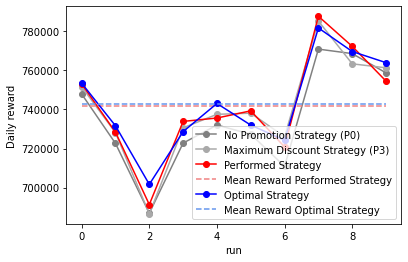

In [1]:
import numpy as np
from scipy.optimize import linear_sum_assignment # library that implement this algorithm
import matplotlib.pyplot as plt
from Context import *

def optimalSolutionsIterations(matching_matrix, verbose = False):
    iteration_matrix = []
    for i in range(4):
        row_ind,col_ind = linear_sum_assignment(matching_matrix,maximize=True) # optimization 
        temp = np.zeros((4,4))
        for ind in range(0,len(row_ind)):
            temp[row_ind[ind],col_ind[ind]] =  matching_matrix[row_ind[ind],col_ind[ind]]
            matching_matrix[row_ind[ind],col_ind[ind]] = np.iinfo(np.int64).min # - infinity
        
        iteration_matrix.append(temp)
    return iteration_matrix


def promoDistribution(iteration_matrix, class_final_distribution, verbose = False):
    """
        w è il peso di ogni iterazione e viene dimezzato ogni volta. 
        le distribuzioni vengono assegnate in base alla (sub)otimal solution che stiamo considerando, in base ai reward che quella configuraizone produce 
    """
    w = 1
    for i in range(4):
        iter_sum = np.sum(iteration_matrix[i])
        coordinates = np.nonzero(iteration_matrix[i])
        for idx in range(len(coordinates[0])):
            class_final_distribution[coordinates[0][idx], coordinates[1][idx]] = (100 * iteration_matrix[i][coordinates[0][idx], coordinates[1][idx]] / iter_sum ) * w
        w = w/2


    return class_final_distribution

def computeClassPromoDistribution(iteration_matrix,class_final_distribution,verbose=False):
    
    """
        calcolo la distribuzione tenendo conto dell'intera matrice, cioè anche della colonna P0 
    """
    promoDistribution(iteration_matrix, class_final_distribution,verbose)   # compute the distribution for promos P0, P1, P2, P3

    # normalize the distributions row by row
    for i in range(0,4):
        sum_per_class=(np.sum(class_final_distribution[i]))
        for j in range(0,4):
            class_final_distribution[i,j] = (class_final_distribution[i,j]*100/sum_per_class)/100  # do not cast to integer!
    return class_final_distribution

#
# Experiment 1 
#

item1_price_full = 2350.0
item2_price_full = 630.0 
class_final_distribution = np.zeros((4,4))  # this 4x4 matrix contains the probablilty that to a user, belonging to a category (row) is given a certaind discount (columns)

# context generation 
ctx = Context()
customer_daily = ctx.customers_daily_instance() # return a vector corresponding to numbers of customers per class 
total_clients = np.sum(customer_daily)
no_promo = int(total_clients * ctx.amount_of_no_promos) # percentage no-promo over the daily total number of customers  
total_promo = total_clients - no_promo


# Calculate of the customers that buy the first item
# Use the conversion rate of the first item (at the defined price), as fractions of buyers
first_item_acquirents = np.zeros((4))

for i in range (0,4):
    first_item_acquirents[i]=int(customer_daily[i] * ctx.conversion_rate_first_element(item1_price_full, i))

# knowing the numbers of customers that bought the first item, we aims to maximize the profit making them buy the second item
# Considering as known the conversion rate of each class, in order to maximize the profit we can determine which discout apply to a class 
# Solved as Matching Problem: match every user category to all the four possible discounts (P0, P1, P2, P3) with the pobability to apply it in order to maximize the profit

# discounted price for the second items
discounted_price = [item2_price_full,
    item2_price_full*(1-ctx.discount_promos[1]),
    item2_price_full*(1-ctx.discount_promos[2]),
    item2_price_full*(1-ctx.discount_promos[3])]

# Matching matrix: rows[0..3] are the user categories; columns[0..3] are the discouts; celles are the weights calculated as (conversion_rate * discounted_price * tot_clients) of that class
matching_matrix = np.zeros((4,4))
for i in range (0,4): #classes
    for j in range (0,4): #promos
        matching_matrix[i,j] = int(discounted_price[j]*(ctx.conversion_rate_second_element(discounted_price[j],i))*first_item_acquirents[i])


# the matching is performed iterating over the matching_matrix four times. Every iteration determine the optimal solution of the matching problem, which allow to maximize the profit
# the iteration_matrix save collect all these oprimal solutions
iteration_matrix = optimalSolutionsIterations(matching_matrix=matching_matrix.copy(),verbose=True)

# compiling the class final distribution matrix 
class_final_distribution = computeClassPromoDistribution(iteration_matrix,class_final_distribution,True)


print(f"\n\nOptimal solution: probability distribution of promos per class (rows: class, col: promos) \n{class_final_distribution.round(2)}\n\n\n")

#
# testing our solution
#

n_experiments = 10

optimal_solution_matrix = np.zeros((4,4))
row_ind, col_ind = (linear_sum_assignment(matching_matrix,maximize=True))
for r,c in zip(row_ind,col_ind):
    optimal_solution_matrix[r,c] = 1

daily_reward_no_promotion_srategy = [] # rewards collected by experiment always appling P0 (no discount) 
daily_reward_max_discount_srategy = [] # rewards collected by experiment always appling P3 (max discount)
daily_reward_promotion_srategy = []    # rewards collected by experiment randomly extracting a promotion, according to our strategy
daily_optimal_solution = []            # rewards collected by experiment always appling the best strategy 

left_promo = total_promo

for t in range(n_experiments):
    daily_reward = [0,0,0,0]
    left_promo = total_promo
    for category in range(len(customer_daily)):
        for customer in range(customer_daily[category]): # for each category emulate the user that purchase the good
            # buy first item 
            customer_probability = ctx.conversion_rate_first_element(item1_price_full,category)
            reward_item1 = ctx.purchase(customer_probability) * item1_price_full
            reward_item2 = 0.0 
            if(reward_item1 > 0): # propose second item
                ########################
                # NO PROMOTION STRATEGY
                ########################
                customer_probability = ctx.conversion_rate_second_element(item2_price_full,category)
                reward_item2 = ctx.purchase(customer_probability) * item2_price_full
                daily_reward[0] += reward_item1 + reward_item2

                ########################
                # BEST PROMOTION STRATEGY
                ########################
                reward_item2 = 0.0
                d_price = np.min(discounted_price)
                customer_probability = ctx.conversion_rate_second_element(d_price,category)
                reward_item2 = ctx.purchase(customer_probability) * d_price
                daily_reward[1] += reward_item1 + reward_item2


                ########################
                # PROMOTION STRATEGY
                ########################
                reward_item2 = 0.0 
                idx_discount = np.random.choice([0,1,2,3], p=class_final_distribution[category])
                # give promo 
                if left_promo == 0:
                    idx_discount = 0
                elif idx_discount != 0:
                    left_promo = left_promo-1
                d_price = discounted_price[idx_discount]
                customer_probability = ctx.conversion_rate_second_element(d_price,category)
                reward_item2 = ctx.purchase(customer_probability) * d_price
                daily_reward[2] += reward_item1 + reward_item2

                ########################
                # OPTIMAL SOLUTION
                ########################
                reward_item2 = 0.0
                idx_discount = np.random.choice([0,1,2,3], p=optimal_solution_matrix[category])
                d_price = discounted_price[idx_discount]
                customer_probability = ctx.conversion_rate_second_element(d_price,category)
                reward_item2 = ctx.purchase(customer_probability) * d_price
                daily_reward[3] += reward_item1 + reward_item2          
            
    daily_reward_no_promotion_srategy.append(daily_reward[0])
    daily_reward_max_discount_srategy.append(daily_reward[1])
    daily_reward_promotion_srategy.append(daily_reward[2])
    daily_optimal_solution.append(daily_reward[3])

plt.figure(0)
plt.xlabel("run")
plt.ylabel("Daily reward")
plt.plot(daily_reward_no_promotion_srategy,'-o', color='grey', label = 'No Promotion Strategy (P0)')
plt.plot(daily_reward_max_discount_srategy,'-o', color='darkgrey', label = 'Maximum Discount Strategy (P3)')
plt.plot(daily_reward_promotion_srategy,'-o', color='red', label = 'Performed Strategy')
plt.plot(n_experiments * [np.mean(daily_reward_promotion_srategy,axis=0)],'--', color='lightcoral', label = 'Mean Reward Performed Strategy')
plt.plot(daily_optimal_solution,'-o', color='blue', label = 'Optimal Strategy')
plt.plot(n_experiments * [np.mean(daily_optimal_solution,axis=0)],'--', color='cornflowerblue', label = 'Mean Reward Optimal Strategy' )

plt.legend()
plt.show()


## STEP 2

Consider the online learning version of the above optimization problem, identify the random variables, and choose a model for them when each round corresponds to a single day. Consider a time horizon of one year.

### Step 2 solution
**Random variables:**

* Daily customers: gaussian

  Normalized gaussian parameters per class (normalizing factor:1000), average and variance:

       1) 0.15 0.03

       2) 0.20 0.03

       3) 0.40 0.05

       4) 0.25 0.04

 

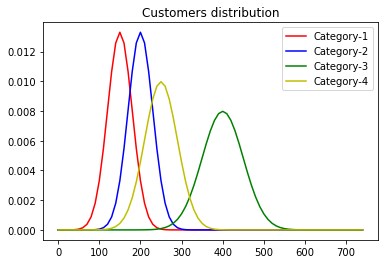

In [2]:
ctx.plot_customers_distribution()

* Buy item1(price) : Bernoulli ~ 0,1 

    
* Buy item2(price) : Bernoulli ~ 0,1


* Reward item1 = buy item 1 * price item 1


* Reward item2 = buy item 1 * buy item 2 * price item2


* Time horizon = 365 days


* Demand curve of the items:


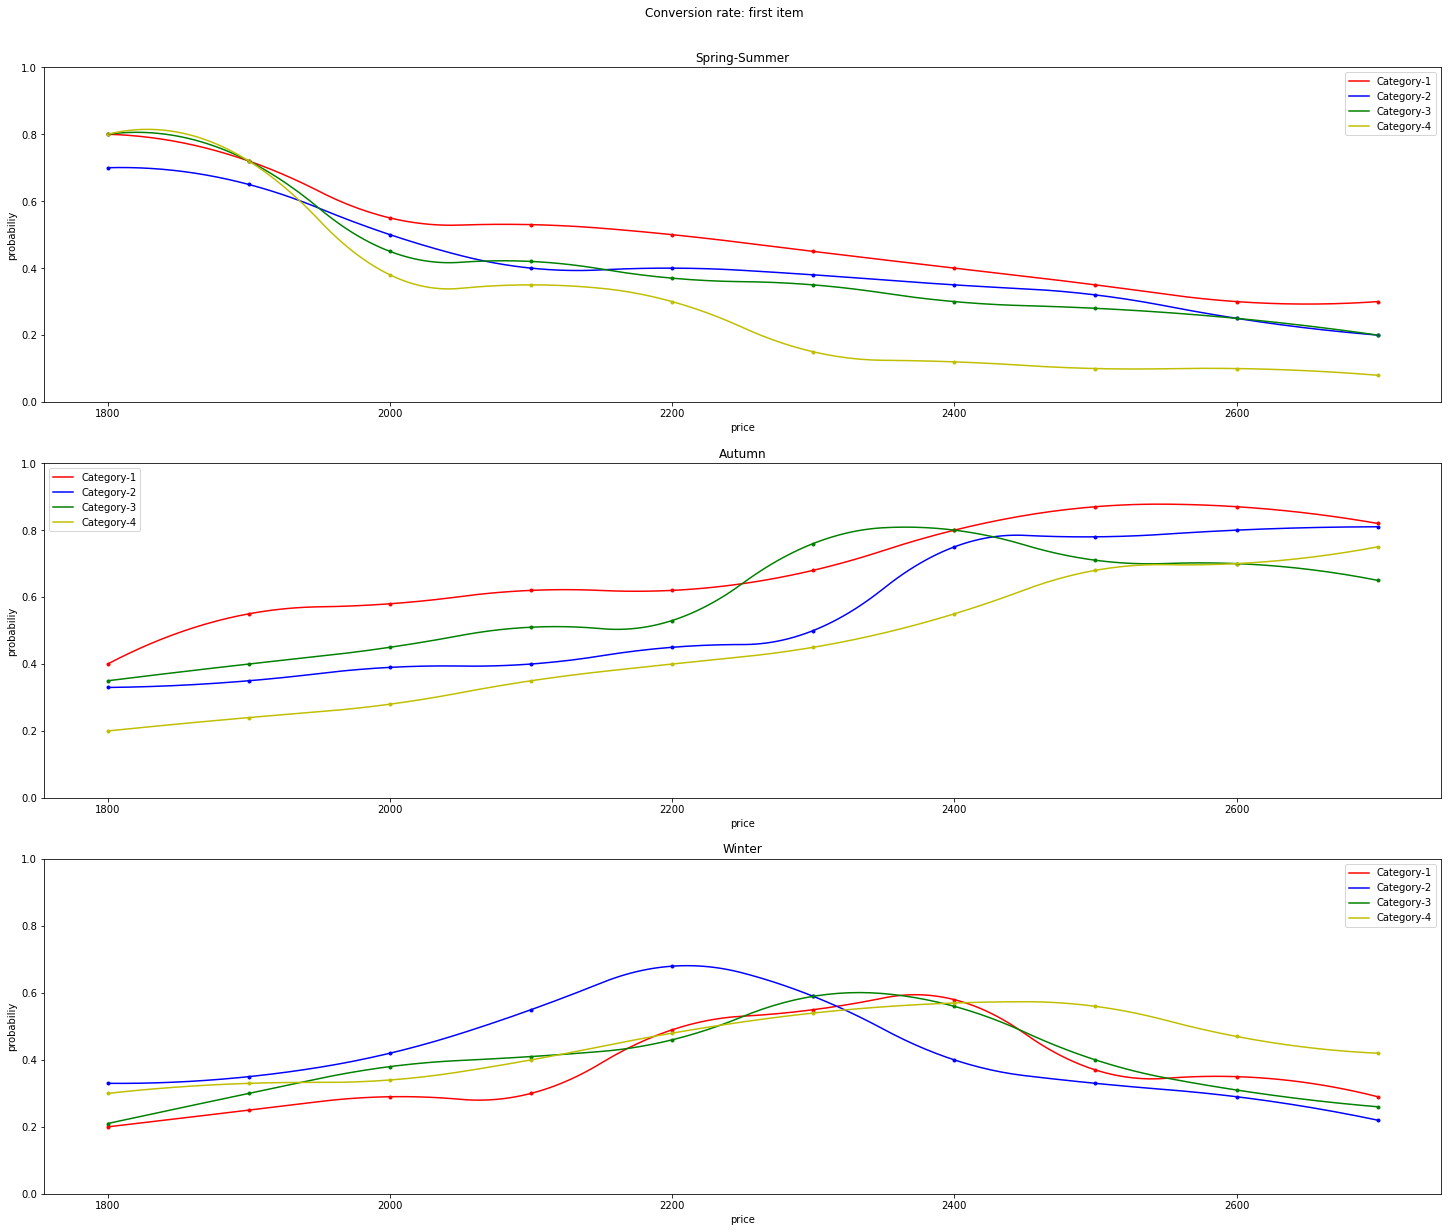

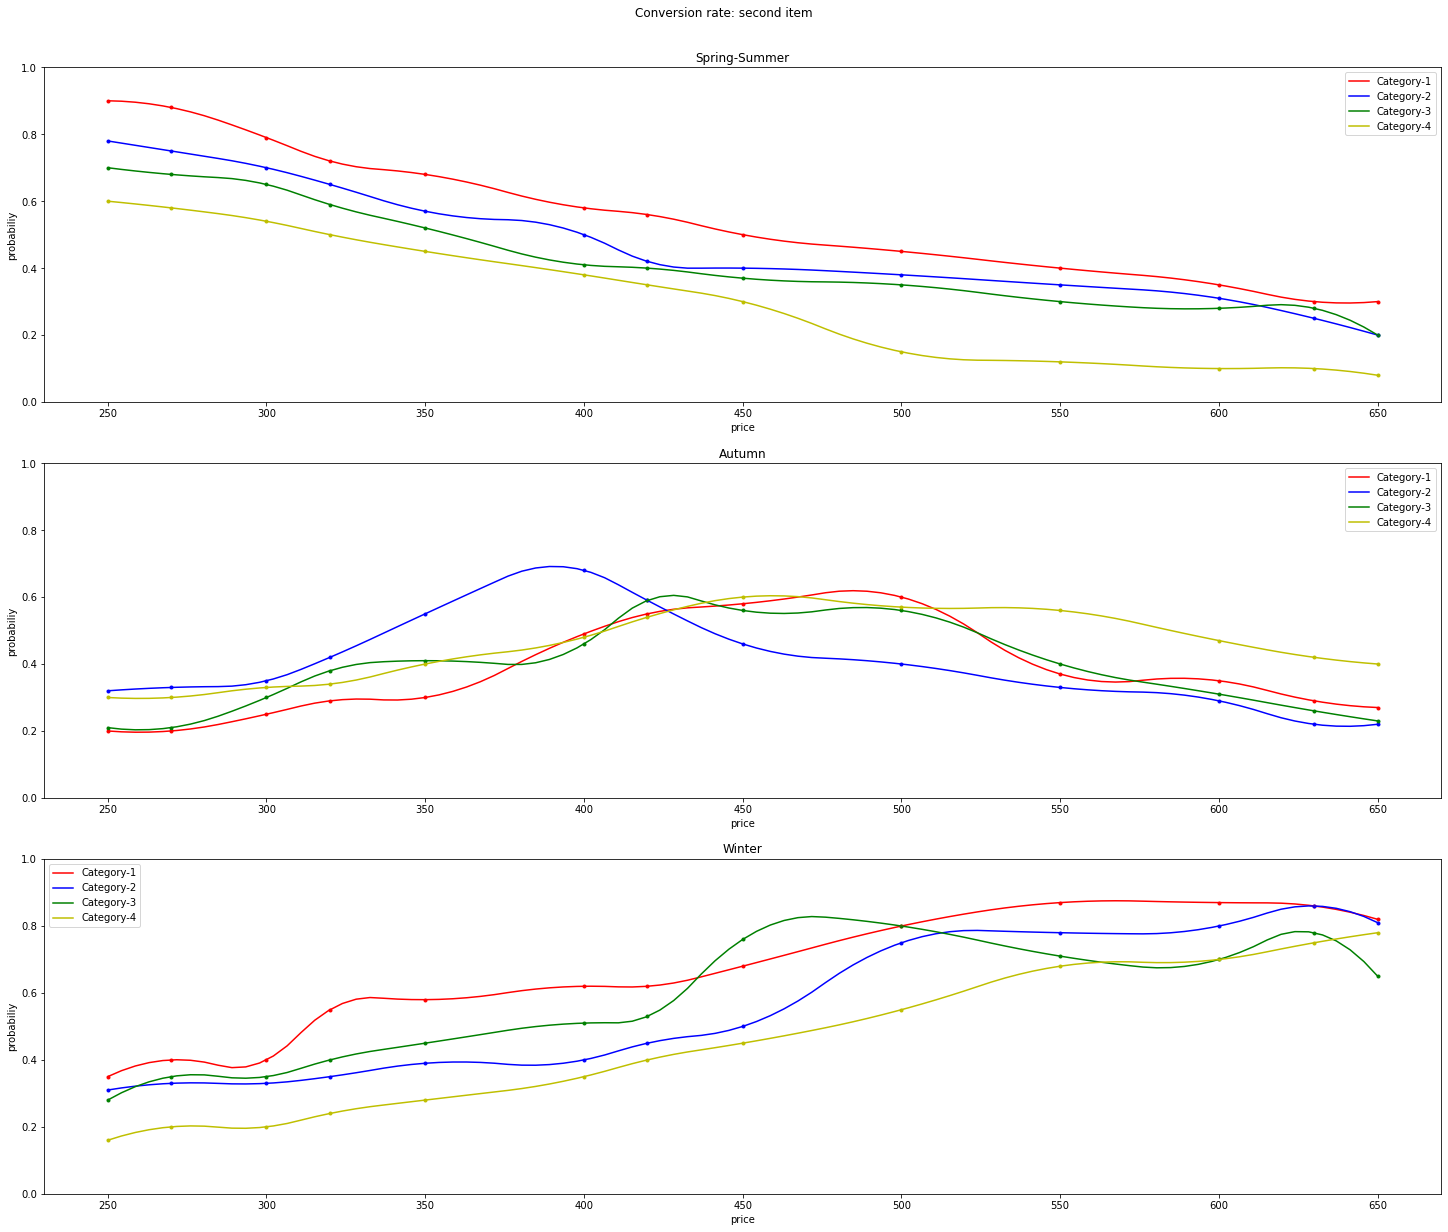

In [3]:
ctx.plot_item1_conversion_rate()
ctx.plot_item2_conversion_rate()

Daily we extract the items prices using an online learner algorithm (pricing or matching), then we simulate the current day obtaining the number of customers per class usign the gaussian distribution, then we calculate the rewards, using the Bernoulli distribution probability to estimate if the single customer buys or not the item1 and item2 at the proposed price. Finally we update the learner, according to the rewards. This procedure is repeated for a time horizon of 365 days and during this period the purpose is to find a solution (composed by the prices and the  assignment of promotions) that maximise the total reward. 